# Decision Tree

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [211]:
#data set 1 (  car evaluation safty)
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
data = pd.read_csv(URL, 
                    sep=",",header=None,names= (['buying','maint','doors', 'person','Lug_boot','safty','evaluation']) )
data.head()

,buying,maint,doors,person,Lug_boot,safty,evaluation
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [212]:
# Divides a set on a specific column
def divideset(rows,column,value):
   # Make a function that tells us if a row is in the first group (true) or the second group (false)
   split_function=None
   if isinstance(value,int) or isinstance(value,float):
      split_function=lambda row:row[column]>=value
   else:
      split_function=lambda row:row[column]==value
   # Divide the rows into two sets and return them
   set1=[row for row in rows if split_function(row)]
   set2=[row for row in rows if not split_function(row)]
   return set1,set2

In [213]:
# Create counts of possible results
def uniquecounts(rows):
   results = {}
   for row in rows:
      r = row[len(row)-1]
      if r not in results: results[r]=0
      results[r]+=1
   return results

In [214]:
# Entropy is the sum of -p(x)log(p(x))
def entropy(rows):
   from math import log
   results=uniquecounts(rows)
   # Now calculate the entropy
   ent=0.0
   for r in results.keys():
      p=float(results[r])/len(rows)
      ent=ent-p*log(p)
   return ent

In [215]:
##Gini Index
def gini(rows):
    results = uniquecounts(rows)
    gini_ind = 1.0
    for r in results.keys():
        p = float(results[r])/len(rows)
        gini_ind = gini_ind - p**2
    return gini_ind

In [216]:
## Class object for decision tree nodes
class decisionnode:
  def __init__(self,col=-1,value=None,results=None,tb=None,fb=None, gain=0, leaf_node=False, feature_lvl_score=None, validation_error=0):
    self.col=col
    self.value=value
    self.results=results
    self.tb=tb
    self.fb=fb
    self.gain=gain
    self.leaf_node =leaf_node
    self.feature_lvl_score= feature_lvl_score
    self.validation_error = validation_error

In [217]:
## Building Decision Tree nodes
def buildtree(rows, depth=100, scoref=entropy): 
  if len(rows)==0: return decisionnode()
  current_score=scoref(rows)
  # Variables to track the best criteria
  best_gain=0.0
  best_criteria= None
  best_sets=None
  feature_lvl_score= {}
  column_count=len(rows[0])-1   
  for col in range(0,column_count):
    temp_feature_lvl_score = 1
    global column_values
    column_values={}            
    for row in rows:
       column_values[row[col]]=1   
    for value in column_values.keys(): 
      (set1,set2)=divideset(rows,col,value)
      # Information gain
      p=float(len(set1))/len(rows) 
      gain=current_score-p*scoref(set1)-(1-p)*scoref(set2)
      if len(set1)>0 and len(set2)>0:
            temp_feature_lvl_score= min(temp_feature_lvl_score, (p*scoref(set1)+(1-p)*scoref(set2)))
      if gain>best_gain and len(set1)>0 and len(set2)>0:
        best_gain=gain
        best_criteria=(col,value)
        best_sets=(set1,set2)
    feature_lvl_score[col]=temp_feature_lvl_score   
  # Create the subbranches   
  if best_gain>0 and depth>0:
    depth = depth-1
    trueBranch=buildtree(best_sets[0], depth, scoref)
    falseBranch=buildtree(best_sets[1], depth, scoref)
    return decisionnode(col=best_criteria[0],value=best_criteria[1],
                        tb=trueBranch,fb=falseBranch, gain=best_gain, results=uniquecounts(rows), 
                        feature_lvl_score=feature_lvl_score)
  else:
    return decisionnode(results=uniquecounts(rows),leaf_node=True,feature_lvl_score=feature_lvl_score)

In [218]:
data_train = data.sample(frac=0.8,random_state=100)
data_test = data.drop(data_train.index)
data_train.reset_index(drop=True,inplace=True)
data_test.reset_index(drop=True,inplace=True)

In [219]:
data_train_lst= data_train.as_matrix()
data_train_lst = data_train_lst.tolist()
data_test_lst= data_test.as_matrix()
data_test_lst = data_test_lst.tolist()

In [220]:
##Building Decision Tree Using Entropy Loss 
depth = 3
Entropy_tree=buildtree(data_train_lst,depth, scoref=entropy)

In [221]:
##Building Decision Tree Using Gini Index
depth = 3
Gini_tree=buildtree(data_train_lst,depth, gini)

In [222]:
##  Breadth first tree traversal level nodes ordering
def get_neighbors(tree_node):
    if tree_node.leaf_node==False:
        return [tree_node.tb, tree_node.fb]
    else:
        return []

def bfs(tree):
    queue = [tree]
    visited = [tree]

    while queue:
        node = queue.pop(0)

        for neighbor in get_neighbors(node):
            if neighbor not in visited:
                queue.append(neighbor)
                visited.append(neighbor)
    return visited

In [223]:
for i in bfs(Entropy_tree):
    print (i.results)

{'unacc': 962, 'acc': 308, 'good': 56, 'vgood': 56}
{'unacc': 468}
{'acc': 308, 'unacc': 494, 'good': 56, 'vgood': 56}
{'unacc': 310}
{'acc': 308, 'unacc': 184, 'good': 56, 'vgood': 56}
{'unacc': 94, 'acc': 55}
{'acc': 253, 'good': 56, 'vgood': 56, 'unacc': 90}


### Plot the results

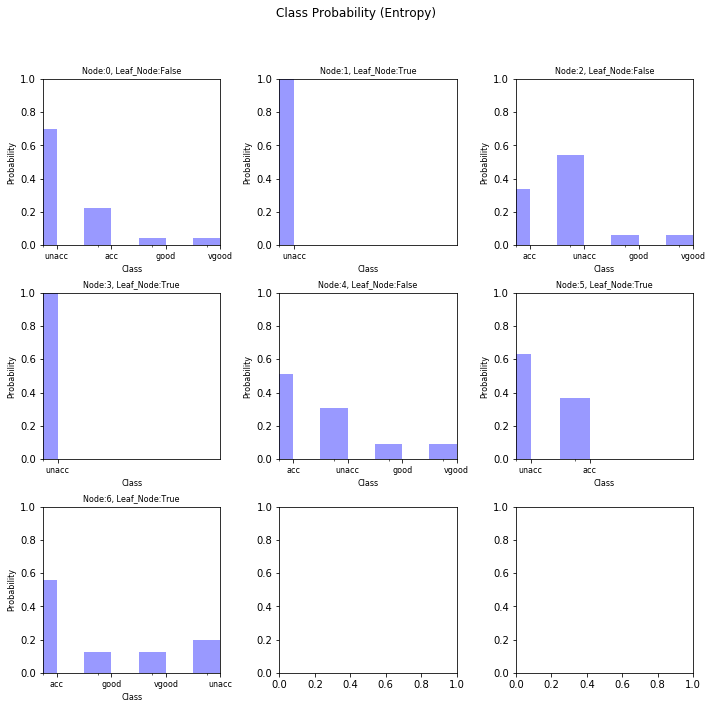

In [224]:
bfs_nodes = bfs(Entropy_tree)
fig, ax = plt.subplots(3, int(np.ceil(len(bfs_nodes)/3)),figsize=(10,10))
for i in range(len(bfs_nodes)):
    j = int(np.floor(i/3))
    list_values = [ v for v in bfs_nodes[i].results.values() ]
    list_values
    sum_list_values = sum(list_values)
    list_values = [x/sum_list_values for x in list_values]
    opacity = 0.4
    bar_width = 0.5
    ax[j,(i-j*3)].bar(range(len(list_values)) ,list_values, bar_width, alpha=opacity,color='b')
    ax[j,(i-j*3)].set_xlabel("Class",fontsize=8)
    ax[j,(i-j*3)].set_ylabel("Probability",fontsize=8)
    ax[j,(i-j*3)].set_xticks(np.arange(len(list_values)), [ k for k in bfs_nodes[i].results ])
    ax[j,(i-j*3)].set_xlim(0,3)
    ax[j,(i-j*3)].set_ylim(0,1)
    ax[j,(i-j*3)].set_title('Node:'+str(i)+', Leaf_Node:'+str(bfs_nodes[i].leaf_node), fontsize=8)
    plt.sca(ax[j,(i-j*3)])
    plt.xticks(np.arange(len(list_values))+0.25,[ k for k in bfs_nodes[i].results.keys() ], fontsize=8)
plt.suptitle('Class Probability (Entropy)')
plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

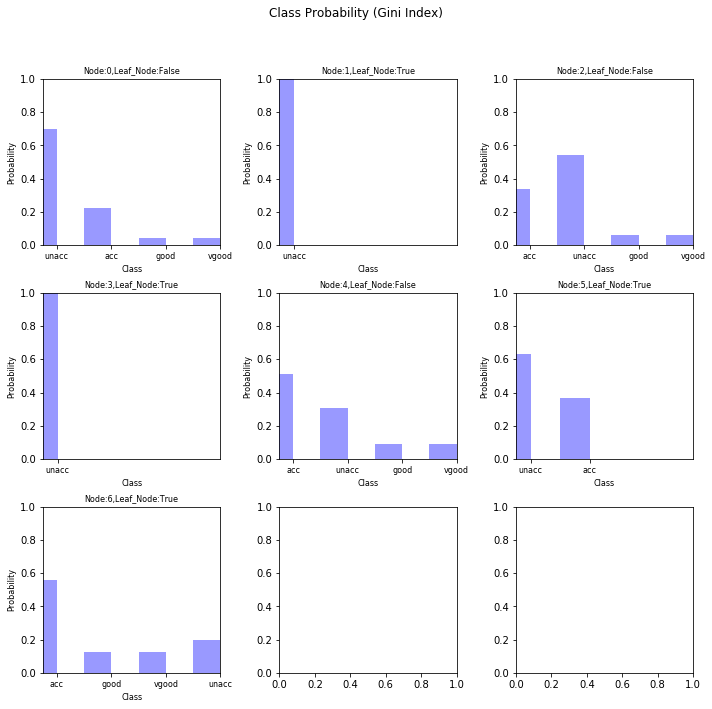

In [225]:
bfs_nodes = bfs(Gini_tree)
fig, ax = plt.subplots(3, int(np.ceil(len(bfs_nodes)/3)),figsize=(10,10))
for i in range(len(bfs_nodes)):
    j = int(np.floor(i/3))
    list_values = [ v for v in bfs_nodes[i].results.values() ]
    list_values
    sum_list_values = sum(list_values)
    list_values = [x/sum_list_values for x in list_values]
    
    opacity = 0.4
    bar_width = 0.5
    ax[j,(i-j*3)].bar(range(len(list_values)) ,list_values, bar_width, alpha=opacity, color='b')
    ax[j,(i-j*3)].set_xlabel("Class",fontsize=8)
    ax[j,(i-j*3)].set_ylabel("Probability",fontsize=8)
    ax[j,(i-j*3)].set_xlim(0,3)
    ax[j,(i-j*3)].set_ylim(0,1)
    ax[j,(i-j*3)].set_title('Node:'+str(i)+',Leaf_Node:'+str(bfs_nodes[i].leaf_node), fontsize=8)
    plt.sca(ax[j,(i-j*3)])
    plt.xticks(np.arange(len(list_values))+0.25,[ k for k in bfs_nodes[i].results.keys() ], fontsize=8)
plt.suptitle('Class Probability (Gini Index)')
plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

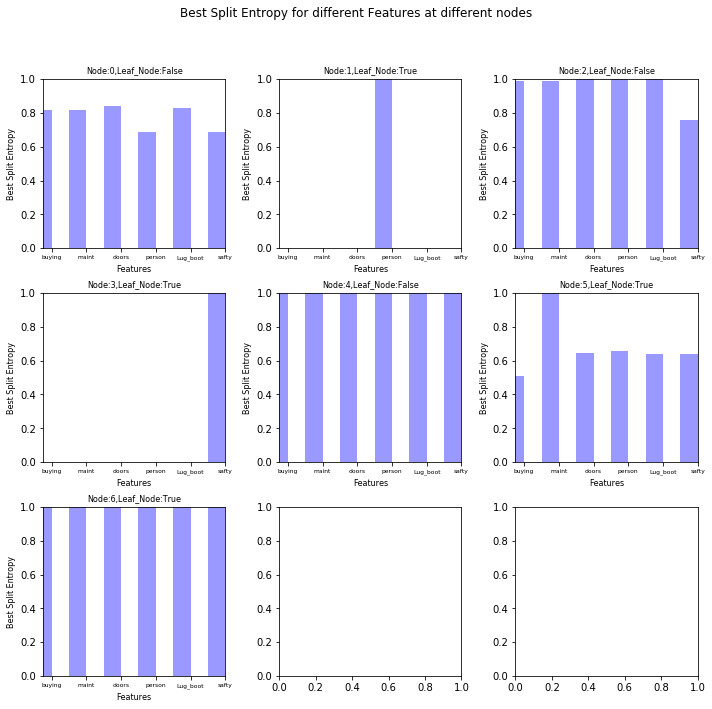

In [226]:
bfs_nodes = bfs(Entropy_tree)
fig, ax = plt.subplots(3, int(np.ceil(len(bfs_nodes)/3)),figsize=(10,10))
for i in range(len(bfs_nodes)):
    j = int(np.floor(i/3))
    list_values = [ v for v in bfs_nodes[i].feature_lvl_score.values() ]
    opacity = 0.4
    bar_width = 0.5
    ax[j,(i-j*3)].bar(range(len(list_values)) ,list_values, bar_width, alpha=opacity,color='b')
    ax[j,(i-j*3)].set_xlabel("Features",fontsize=8)
    ax[j,(i-j*3)].set_ylabel("Best Split Entropy",fontsize=8)
    ax[j,(i-j*3)].set_xlim(0,4)
    ax[j,(i-j*3)].set_ylim(0,1)
    ax[j,(i-j*3)].set_title('Node:'+str(i)+',Leaf_Node:'+str(bfs_nodes[i].leaf_node), fontsize=8)
    plt.sca(ax[j,(i-j*3)])
    plt.xticks(np.arange(len(list_values))+0.25,['buying','maint','doors', 'person','Lug_boot','safty'], fontsize=6)
plt.suptitle('Best Split Entropy for different Features at different nodes')
plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

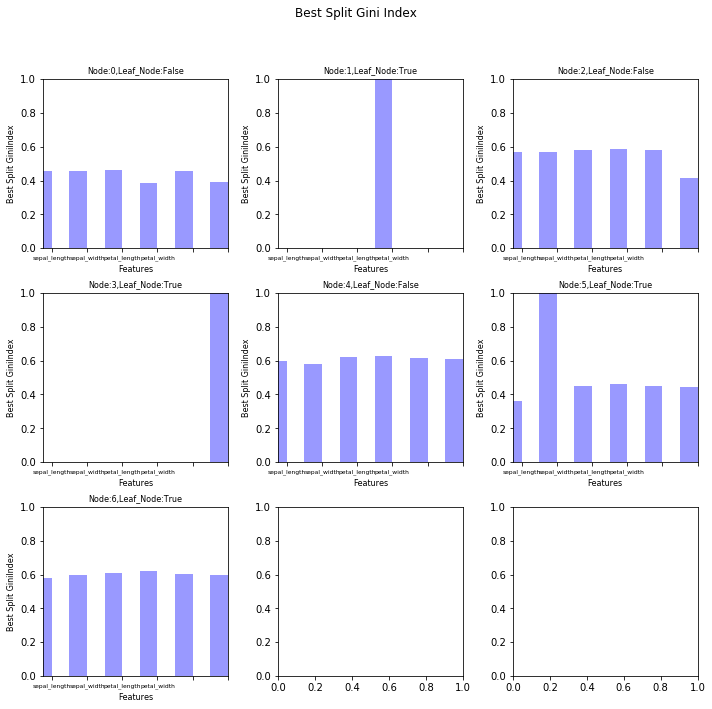

In [227]:
bfs_nodes = bfs(Gini_tree)
fig, ax = plt.subplots(3, int(np.ceil(len(bfs_nodes)/3)),figsize=(10,10))

for i in range(len(bfs_nodes)):
    j = int(np.floor(i/3))
    list_values = [ v for v in bfs_nodes[i].feature_lvl_score.values() ]

    opacity = 0.4
    bar_width = 0.5
    ax[j,(i-j*3)].bar(range(len(list_values)) ,list_values, bar_width, alpha=opacity, color='b')
    ax[j,(i-j*3)].set_xlabel("Features",fontsize=8)
    ax[j,(i-j*3)].set_ylabel("Best Split GiniIndex",fontsize=8)
    ax[j,(i-j*3)].set_xlim(0,4)
    ax[j,(i-j*3)].set_ylim(0,1)
    ax[j,(i-j*3)].set_title('Node:'+str(i)+',Leaf_Node:'+str(bfs_nodes[i].leaf_node), fontsize=8)
    plt.sca(ax[j,(i-j*3)])
    plt.xticks(np.arange(len(list_values))+0.25,['sepal_length','sepal_width','petal_length', 'petal_width'], fontsize=6)
plt.suptitle('Best Split Gini Index')
plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

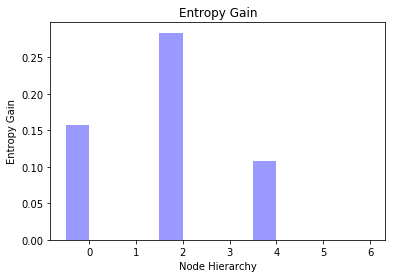

In [228]:
bfs_nodes = bfs(Entropy_tree)
entropy_gain = {}
for i in range(len(bfs_nodes)):
    entropy_gain[i]= bfs_nodes[i].gain
opacity = 0.4
bar_width = 0.5
entropy_gain_key = [x for x in entropy_gain.keys()]
entropy_gain_value = [x for x in entropy_gain.values()]
plt.bar(range(len(entropy_gain)) ,entropy_gain_value, bar_width, alpha=opacity,color='b')
plt.xticks(np.arange(len(entropy_gain))+0.25,entropy_gain_key)
plt.xlabel("Node Hierarchy")
plt.ylabel("Entropy Gain")
plt.title("Entropy Gain")
plt.show()

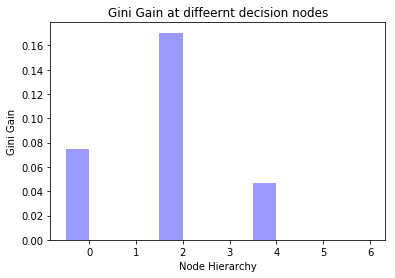

In [230]:
bfs_nodes = bfs(Gini_tree)
entropy_gain = {}
for i in range(len(bfs_nodes)):
    entropy_gain[i]= bfs_nodes[i].gain
opacity = 0.4
bar_width = 0.5
entropy_gain_key = [x for x in entropy_gain.keys()]
entropy_gain_value = [x for x in entropy_gain.values()]
plt.bar(range(len(entropy_gain)) ,entropy_gain_value, bar_width, alpha=opacity, color='b')
plt.xticks(np.arange(len(entropy_gain))+0.25,entropy_gain_key)
plt.xlabel("Node Hierarchy")
plt.ylabel("Gini Gain")
plt.title("Gini Gain at diffeernt decision nodes")
plt.show()

### Test Data

In [231]:
## Functions to predict on test data
def classify(observation,tree):
  if tree.leaf_node==True:
#     return max(tree.results, key=tree.results.get)
    return [max(tree.results.keys(), key=(lambda k: tree.results[k])),tree]
  else:
    v=observation[tree.col]
    branch=None
    if isinstance(v,int) or isinstance(v,float):
      if v>=tree.value: branch=tree.tb
      else: branch=tree.fb
    else:
      if v==tree.value: branch=tree.tb
      else: branch=tree.fb
    return classify(observation,branch)

def tree_predict(test_data,tree):
    predicted_value = []
    for row in test_data:
        predicted_value.append(classify(row,tree))
    return predicted_value

In [232]:
## Prediction on test data using entropy loss decision tree
test_pred = tree_predict(data_test_lst,Entropy_tree)

In [233]:
## Log loss(Entropy loss) on test data
import sys
test_pred = tree_predict(data_test_lst,Entropy_tree)
test_resultDF = pd.DataFrame({'Actual_Label':data_test["evaluation"],'Predicted_Label':np.array(test_pred)[:,0], 'Predicted_Group':np.array(test_pred)[:,1]})
test_group = test_resultDF.Predicted_Group.unique()
pred_total_entropy = 0.0
for i in range(len(test_group)):
    temp = test_resultDF.ix[test_resultDF.Predicted_Group==test_group[i],"Actual_Label"].tolist()
    pred_total_entropy += (entropy(temp))*(len(temp)/len(test_resultDF))
initial_entropy = entropy(test_resultDF["Actual_Label"].tolist())
entropy_loss = initial_entropy - pred_total_entropy
entropy_loss
print("Accuracy: " + str(entropy_loss))

Accuracy: 0.0709049890155393


C:\Anacounda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [234]:
pd.crosstab(test_resultDF.Actual_Label, test_resultDF.Predicted_Label)

Predicted_Label,acc,unacc
Actual_Label,,
acc,59,17
good,13,0
unacc,40,208
vgood,9,0


In [235]:
## Prediction on test data using gini loss decision tree
test_pred = tree_predict(data_test_lst,Gini_tree)

In [236]:
## Log loss(Entropy loss) on test data
test_pred = tree_predict(data_test_lst,Gini_tree)
test_resultDF = pd.DataFrame({'Actual_Label':data_test["evaluation"],'Predicted_Label':np.array(test_pred)[:,0], 'Predicted_Group':np.array(test_pred)[:,1]})
test_group = test_resultDF.Predicted_Group.unique()

pred_total_entropy = 0.0
for i in range(len(test_group)):
    temp = test_resultDF.ix[test_resultDF.Predicted_Group==test_group[i],"Actual_Label"].tolist()
    pred_total_entropy += (entropy(temp))*(len(temp)/len(test_resultDF))

initial_entropy = entropy(test_resultDF["Actual_Label"].tolist())
entropy_loss = initial_entropy - pred_total_entropy
print("Accuracy: " + str(entropy_loss))

Accuracy: 0.0709049890155393


C:\Anacounda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [237]:
pd.crosstab(test_resultDF.Actual_Label, test_resultDF.Predicted_Label)

Predicted_Label,acc,unacc
Actual_Label,,
acc,59,17
good,13,0
unacc,40,208
vgood,9,0


## Pruning The Decision Tree (Post Pruning: Reduced Error Prunning)

In [238]:
## Test, Train and Validation sets
data_train = data.sample(frac=0.34,random_state=100)
remaining_data = data.drop(data_train.index)
data_train.reset_index(drop=True,inplace=True)

In [239]:
data_test = remaining_data.sample(frac=0.5,random_state=100)
data_Validation = remaining_data.drop(data_test.index)
data_test.reset_index(drop=True,inplace=True)
data_Validation.reset_index(drop=True,inplace=True)

In [240]:
print(data_train.shape)
print(data_test.shape)
print(data_Validation.shape)

(588, 7)
(570, 7)
(570, 7)


In [241]:
data_train_lst= data_train.as_matrix()
data_train_lst = data_train_lst.tolist()

data_test_lst= data_test.as_matrix()
data_test_lst = data_test_lst.tolist()

data_Validation_lst= data_Validation.as_matrix()
data_Validation_lst = data_Validation_lst.tolist()

In [242]:
##bulding complete tree
complete_tree = buildtree(data_train_lst, scoref=entropy)

In [243]:
temp = tree_predict(data_Validation_lst,complete_tree)
pd.crosstab(np.array(temp)[:,0],data_Validation["evaluation"])

evaluation,acc,good,unacc,vgood
row_0,,,,
acc,107,3,6,4
good,4,16,0,0
unacc,8,1,399,0
vgood,1,5,0,16


In [244]:
def build_error(row,tree):
    if (max(tree.results.keys(), key=(lambda k: tree.results[k])) != row[-1]):
        tree.validation_error = tree.validation_error+1
    if tree.leaf_node==True:
        return
    else:
        v=row[tree.col]
        branch=None
        if isinstance(v,int) or isinstance(v,float):
            if v>=tree.value: branch=tree.tb
            else: branch=tree.fb
        else:
            if v==tree.value: branch=tree.tb
            else: branch=tree.fb
    return build_error(row,branch)

In [245]:
for row in data_Validation_lst:
    build_error(row,complete_tree)

In [246]:
print("Validation_error: "+str(complete_tree.validation_error))

Validation_error: 165


In [247]:
## Printing decision tree at Node hierarchical Level
def printtree_error(tree,indent=''):
   # Is this a leaf node?
    if tree.leaf_node==True:
        print('Validation_error:'+str(tree.validation_error))
    else:
        print(str(tree.col)+':'+str(tree.value)+'  '+'Validation_error:'+str(tree.validation_error))
        # Print the branches
        print(indent+'True->', end=" ")
        printtree_error(tree.tb,indent+'  ')
        print(indent+'False->', end=" ")
        printtree_error(tree.fb,indent+'  ')

In [248]:
printtree_error(complete_tree)

3:2  Validation_error:165
True-> Validation_error:0
False-> 5:low  Validation_error:165
  True-> Validation_error:0
  False-> 0:low  Validation_error:125
    True-> 1:vhigh  Validation_error:33
      True-> 5:high  Validation_error:4
        True-> Validation_error:0
        False-> 4:big  Validation_error:3
          True-> Validation_error:0
          False-> 2:5more  Validation_error:0
            True-> 4:small  Validation_error:0
              True-> Validation_error:0
              False-> Validation_error:0
            False-> Validation_error:0
      False-> 5:high  Validation_error:31
        True-> 4:small  Validation_error:10
          True-> 2:2  Validation_error:3
            True-> Validation_error:1
            False-> 1:high  Validation_error:3
              True-> Validation_error:0
              False-> Validation_error:0
          False-> 2:2  Validation_error:2
            True-> 4:med  Validation_error:2
              True-> 1:high  Validation_error:0
             

In [249]:
number_of_nodes = bfs(Entropy_tree)